Feb 19th 2025  
Seems to be weird issue where variance of change in angle from multiple short simulations looks different from diffusion curve calculated from a single long sim.

Oh I think I was using exp_fi for one and tanh for other. Fix that and check.

In [1]:
import sys, os, glob
import datetime, time

import numpy as np
from numpy import linalg as nla
from numpy.random import default_rng

import matplotlib.pyplot as plt

gen_fns_dir = os.path.abspath('../shared')
sys.path.append(gen_fns_dir)

import ring_net_fns as rnf
import angle_fns_new as af

%matplotlib inline

curr_seed=int((time.time()%1)*(2**31))
print('Seed= {}'.format(curr_seed))
rng = default_rng(seed=curr_seed)

curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'

Seed= 1118991872


In [2]:
# Shared params
n_neurons = 300
pref_angles, W = rnf.get_W_and_pref_angles(n_neurons, rnf.bf_conn_profile)
bias = -2. * np.ones(n_neurons) # Used this for exp

# Initial conditions
j0 = np.round(n_neurons*0.45).astype(int)
j1 = np.round(n_neurons*0.55).astype(int)
ics = np.zeros(n_neurons)
ics[j0:j1] = 1

# Short
t_max = 15.1
params_short = {'dt' : 5e-4, 'tau' : 1e-2, 'ics' : ics, 'bias' : bias, 'fi' : rnf.exp_fi}
params_short['nSteps'] = int(t_max/params_short['dt'])
t_short = np.arange(params_short['nSteps'])*params_short['dt']

# Long
t_max = 200
params_long = {'dt' : 5e-4, 'tau' : 1e-2, 'ics' : ics, 'bias' : bias, 'fi' : rnf.exp_fi}
params_long['nSteps'] = int(t_max/params_long['dt'])
t_long = np.arange(params_long['nSteps'])*params_long['dt']


In [3]:
# Run short a bunch of times
times_sample_angle = np.array([1, 6, 11])
time_idx_sample_angle = np.round(times_sample_angle/params_short['dt']).astype(int)
n_sims = 30
angs_short = np.zeros((n_sims, len(times_sample_angle)))

tic = time.time()
for i in range(n_sims):
    s, rates_short = rnf.simulate_lnp_net(W, params_short)
    dec_angle_pv = np.array([af.population_vector_decoder(r, pref_angles) for r in rates_short[time_idx_sample_angle]])
    angs_short[i] = np.array(dec_angle_pv)
print('Sim time ', time.time()-tic)


Sim time  31.733789920806885


In [4]:
# Run long once
tic = time.time()
s_long, rates_long = rnf.simulate_lnp_net(W, params_long)
print('Sim time ', time.time()-tic)
theta_long = np.array([af.population_vector_decoder(r, pref_angles) for r in rates_long])

Sim time  27.576086044311523


1.9078095613208745
1.9311991803269402


NameError: name 'params' is not defined

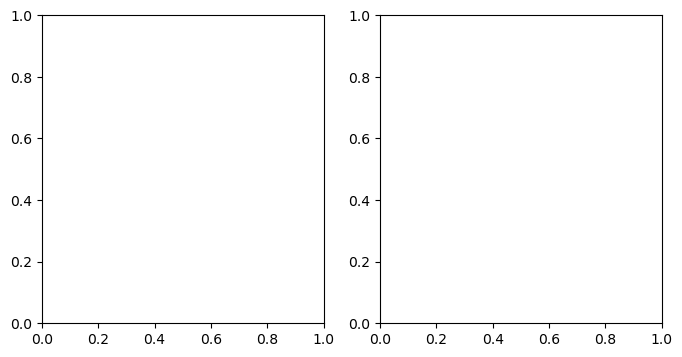

In [5]:
# Get change on short timescale
for i in range(len(times_sample_angle)-1):
    diffs = af.angular_diff(angs_short[:,i], angs_short[:,i+1])
    print(np.var(diffs))

# Get diffusion curve from long
taus, variances = af.compute_diffusion_curve(theta_long, max_tau=np.round(5.1/params_long['dt']).astype(int))
D, slope, intercept = af.compute_diffusion_constant(params_long['dt']*taus, np.array(variances))


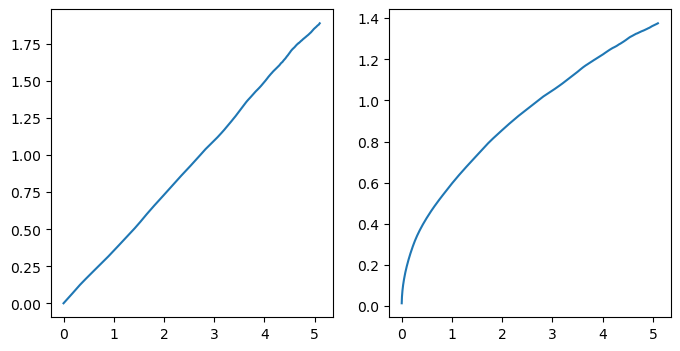

In [6]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(taus*params_long['dt'], variances)
ax[1].plot(taus*params_long['dt'], np.sqrt(variances))